# Exploring Land Cover Data

:::{eval-rst}
:opticon:`tag`
:badge:`[Environment],badge-primary`
:badge:`Exploration,badge-secondary`
:::

## Context
### Purpose
This notebook introduces manipulation and exploratory analysis of classified land cover data. 

### Dataset description
There are now many classified (categorical) land cover data productes that are useful for Environmental Data Science. These include:
- [ESA CCI land cover](https://www.esa-landcover-cci.org/), 300m spatial resolution global extent for years 1992-2015 
- [Copernicus Global Land Cover](https://zenodo.org/communities/copernicus-land-cover), 100m spatial resolution global extent for years 2015-2019 
- [USGS LCMAP](https://www.usgs.gov/special-topics/lcmap/data), 30m spatial resolution for USA for years 1985-2020
- [UKCEH LCMs](https://www.ceh.ac.uk/data/ukceh-land-cover-maps), various spatial resolutions for UK for various years 1990-2020
- [mapbiomas](https://mapbiomas.org/en), 30m spatial resolution for Brazil for years 1985-2020
- [Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class), 10m spatial resolution global extent for 2017-2021

These products are provided as 2D rasters (spatial) or 3D data cubes (spatio-temporal). The number and classification of discrete land cover classes varies between products, but at their most basic will distinguish between broad land covers such as 'grassland', 'forest' and 'built-up'. The nominal (categorical) character of the data influences the types of analysis appropriate. 

### Highlights
* Read land cover product data
* Plot categorical maps
* Analyse aggregate change (through bar charts and similar visualisation) 
* Analyse zonal change (using ancillary vector data)
* Analyse pixel-by-pixel change (including use of sankey diagrams)

### Contributions

#### Notebook
- James Millington (author), Dept of Geography, King's College London, [@jamesdamillington](https://github.com/jamesdamillington)

#### Dataset
- [Esri](https://www.esri.com/) (licensor)
- [Impact Observatory](https://www.impactobservatory.com/) (processor, producer, licensor)
- [Microsoft](https://planetarycomputer.microsoft.com/) (host)

#### Code
- Data loading code built on snippet [from @acocac](https://github.com/alan-turing-institute/environmental-ds-book/issues/99#issuecomment-1185550940) via [ODC.stac docs](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html) and a [Microsoft Planetary example notebook](https://planetarycomputer.microsoft.com/dataset/io-lulc#Example-Notebook).  

## Load libraries

In [1]:
#system
import os
import warnings
warnings.filterwarnings(action='ignore')

#data handling
import pystac_client
import geopandas as gpd
import odc.stac
import rasterio as rio
#from rasterio import features
from pystac.extensions.item_assets import ItemAssetsExtension
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import xarray as xr
from rasterstats import zonal_stats

#visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
import seaborn as sns

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder.*

In [2]:
notebook_folder = './general-exploration-landcover'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## 1. Load data
*Load full dataset from original or mirror sources. If the license of the dataset permits, we suggest creating sample data (preprocessed) for the notebook stored in a data repository e.g. Zenodo.*

This notebook uses [data from Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class), 10m spatial resolution global extent for 2017-2021. These data are hosted online by [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) which enable you, the user, to run the code in the cloud (e.g. via binder). However, accessing the data from the cloud adds some steps that would not be necssary had you downloaded the data to your local machine. Consequently, in future for your own work you might ignore these first _Load cload data_ code blocks and work from _Load local data_.   

### Load Cloud Data

In [3]:
#Specify center point of the study area
x, y = (-56.1, -12.2)  #area in NE MT (need a large enough area for zonal aggregation by municipality)
#x, y = (-44.0, -17.50)

#define a square bounding box for the study area
km2deg = 1.0 / 111
xd = 200 * km2deg
yd = 325 * km2deg
study_bbox = (x - xd, y - yd, x + xd, y + yd)

In [4]:
study_bbox

(-57.9018018018018, -15.127927927927928, -54.2981981981982, -9.27207207207207)

In [5]:
#use pystac-client
#https://pystac-client.readthedocs.io/en/latest/
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

print(f"Object class: {type(catalog)}")
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")

Object class: <class 'pystac_client.client.Client'>
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [6]:
#https://pystac-client.readthedocs.io/en/latest/tutorials/pystac-client-introduction.html#API-Search
query = catalog.search(
    collections=["io-lulc-9-class"],
    limit=100,
    bbox=study_bbox
)

#https://pystac-client.readthedocs.io/en/latest/tutorials/pystac-client-introduction.html#Items
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

print(items)

Found: 5 datasets
[<Item id=21L-2021>, <Item id=21L-2020>, <Item id=21L-2019>, <Item id=21L-2018>, <Item id=21L-2017>]


In [7]:
#view metadata
stac_json = query.get_all_items_as_dict()     # Convert STAC items into a GeoJSON FeatureCollection
#stac_json

In [8]:
gdf = gpd.GeoDataFrame.from_features(stac_json)  #convert GeoJSON to GeoPandas to viewing differently
gdf.head()

,geometry,datetime,proj:bbox,proj:epsg,io:tile_id,proj:shape,end_datetime,proj:transform,start_datetime,io:supercell_id
0,"POLYGON ((-54.00000 -8.00195, -54.00000 -16.00...",None,"[169256.89710350562, 8228747.785209756, 830736...",32721,21L,"[88695, 66148]",2022-01-01T00:00:00Z,"[10.0, 0.0, 169256.89710350562, 0.0, -10.0, 91...",2021-01-01T00:00:00Z,21L
1,"POLYGON ((-54.00000 -8.00195, -54.00000 -16.00...",None,"[169256.89710350562, 8228747.785209756, 830736...",32721,21L,"[88695, 66148]",2021-01-01T00:00:00Z,"[10.0, 0.0, 169256.89710350562, 0.0, -10.0, 91...",2020-01-01T00:00:00Z,21L
2,"POLYGON ((-56.94870 -16.33045, -56.94870 -16.3...",2019-06-01T00:00:00Z,"[169256.89710350562, 8228747.785209756, 830736...",32721,21L,"[88695, 66148]",2020-01-01T00:00:00Z,"[10.0, 0.0, 169256.89710350562, 0.0, -10.0, 91...",2019-01-01T00:00:00Z,21L
3,"POLYGON ((-56.94870 -16.33045, -56.94870 -16.3...",2018-06-01T00:00:00Z,"[169256.89710350562, 8228747.785209756, 830736...",32721,21L,"[88695, 66148]",2019-01-01T00:00:00Z,"[10.0, 0.0, 169256.89710350562, 0.0, -10.0, 91...",2018-01-01T00:00:00Z,21L
4,"POLYGON ((-56.94870 -16.33045, -56.94870 -16.3...",2017-06-01T00:00:00Z,"[169256.89710350562, 8228747.785209756, 830736...",32721,21L,"[88695, 66148]",2018-01-01T00:00:00Z,"[10.0, 0.0, 169256.89710350562, 0.0, -10.0, 91...",2017-01-01T00:00:00Z,21L


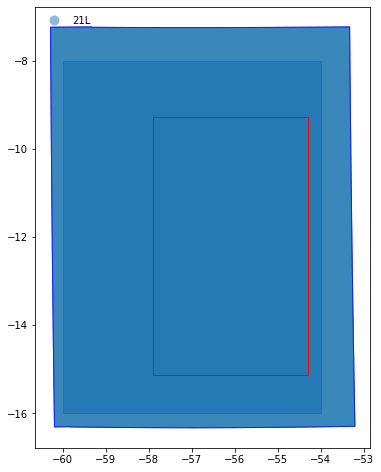

In [9]:
#plot to check study area does not cover multiple lc images 
fig, axes = plt.subplots(figsize=(6, 12))

gdf.plot(
    "io:tile_id",
    ax=axes,
    edgecolor="blue",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    #,
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)

#add polygon to show our study area
lon_points = [study_bbox[0], study_bbox[0], study_bbox[2], study_bbox[2]]
lat_points = [study_bbox[1], study_bbox[3], study_bbox[3], study_bbox[1]]
study_poly = Polygon(zip(lon_points, lat_points))
crs = {'init': 'epsg:4326'}
sa_polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[study_poly])  
sa_polygon.plot(edgecolor="red", facecolor="none", ax=axes)

plt.show()

In [10]:
SMepsg = 3857  #https://epsg.io/3857 Geographic crs, units are m

SMepsg_str = "epsg:{0}".format(SMepsg)

datares = 300
#https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html
lc100 = odc.stac.load(
    items,             #load the items from our query above
    groupby="start_datetime",  #create spatial layers that have the same timestamp     
    chunks={},         #use Dask to speed loading
    #next lines load study area at 100m resolution
    #without these entire image is returned at original resolution (10m)
    crs=SMepsg_str,    #specify the desired crs 
    resolution=datares,    #specify the desired spatial resolution (units as per crs)
    bbox=study_bbox,    #specify bounding box in Lon/Lat (ignores crs units, use x,y to use crs units)
    resampling="mode"  #ensure sensible type for categorical data (options seem to be as for datacube.Datacube.load)
)
lc100

<xarray.Dataset>
Dimensions:      (y: 2225, x: 1338, time: 5)
Coordinates:
  * y            (y) float64 -1.037e+06 -1.037e+06 ... -1.704e+06 -1.704e+06
  * x            (x) float64 -6.446e+06 -6.445e+06 ... -6.045e+06 -6.045e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2017-06-01 2018-06-01 ... 2021-01-01
Data variables:
    data         (time, y, x) float32 dask.array<chunksize=(1, 2225, 1338), meta=np.ndarray>

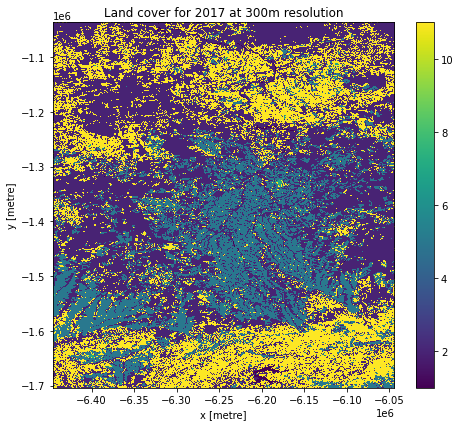

In [11]:
ts='2017'  #which year layer
lc100.sel(time=ts).isel(time=0).to_array("band").plot.imshow(
        col="band",
        size=6
    )

#plt.title("Land cover for {0}".format(lc100["time"][ts].values.astype('datetime64[D]')))   #https://stackoverflow.com/a/26895491
plt.title("Land cover for {0} at {1}m resolution".format(ts, datares))
plt.show()

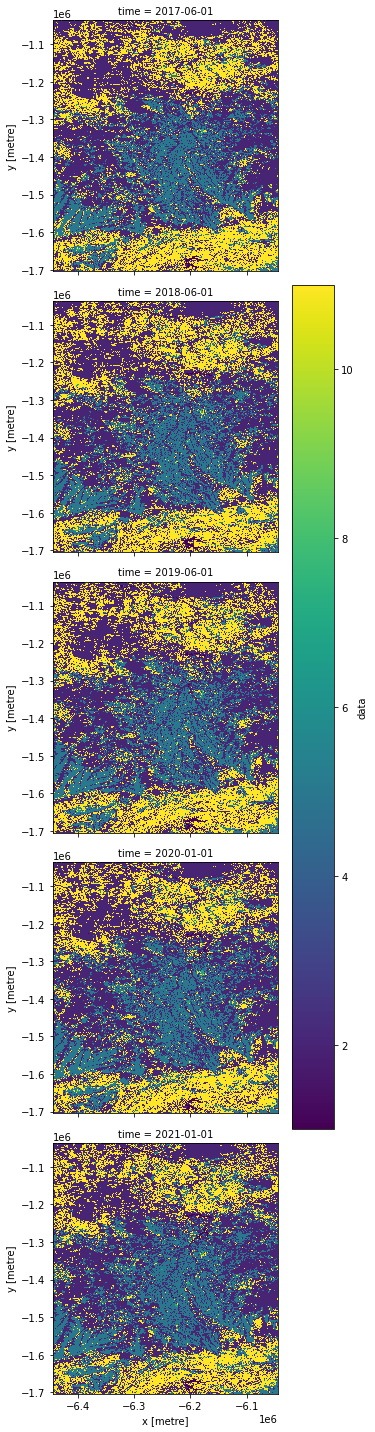

In [12]:
lc100['data'].plot(row="time", size=4)  
plt.show()

### Load Local Data

(Example, should you want to open data from a local drive)

In [13]:
url2021 = items[0].assets["data"].href
url2021

'https://ai4edataeuwest.blob.core.windows.net/io-lulc/nine-class/21L_20210101-20220101.tif'

In [14]:
import rioxarray
import xarray
lc2021rx = xarray.open_dataset(url2021, engine="rasterio")

lc2021rio = rioxarray.open_rasterio(url2021)

In [15]:
print(type(lc2021rx))
lc2021rx

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:      (band: 1, x: 66148, y: 88695)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.693e+05 1.693e+05 ... 8.307e+05 8.307e+05
  * y            (y) float64 9.116e+06 9.116e+06 ... 8.229e+06 8.229e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

## 2. Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. Holoviews, Panel, Bokeh.*

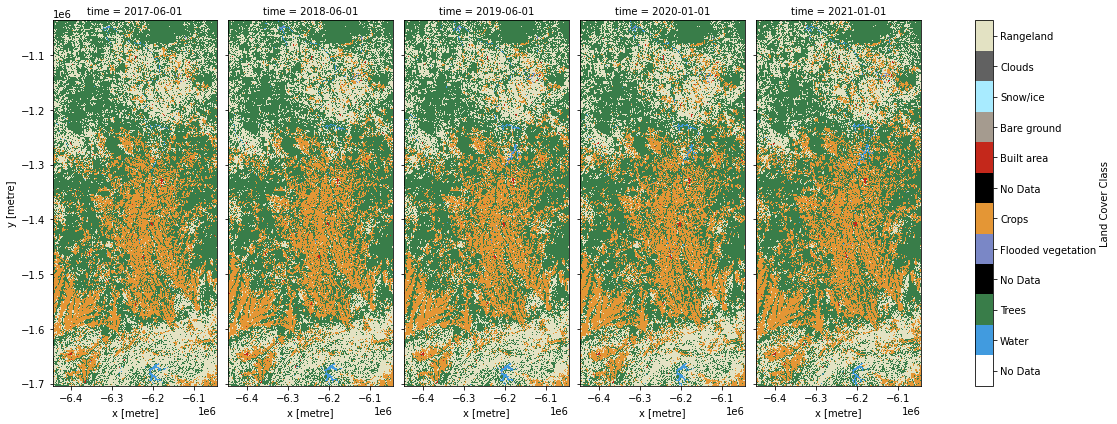

In [17]:
#class names and IDs are held in an 'asset' of the collection 
collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

iaa = ia.item_assets["data"]

#get the names of the land cover classes with their ID in the raster (as a dictionary, name:ID)
class_names = {iaa["summary"]: iaa["values"][0] for iaa in iaa.properties["file:values"]}

#flip the keys:values in the dictionary (to create ID:name)
values_to_classes = {v: k for k, v in class_names.items()}

max_class = max(values_to_classes.keys())

with rio.open(items[0].assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max_class+1)
    ]  # transform to matplotlib color format

lc_cmap = ListedColormap(colormap)

vmin = 0
vmax = lc_cmap.N

p = lc100.data.plot(
    col="time",
    cmap=lc_cmap,
    vmin=vmin,
    vmax=vmax,
    figsize=(16, 6),
)
ticks = np.linspace(start=vmin+0.5, stop=vmax-0.5, num=vmax)
labels = [values_to_classes.get(i, "No Data") for i in range(vmax)]
p.cbar.set_ticks(ticks, labels=labels)
p.cbar.set_label("Land Cover Class")

<a name="section3"></a>
## 3. Analysing Aggregate Change

In this section we're going to examine land cover change across the study area. Our aim is to produce a bar plot that shows increases or decreases in land area for each land cover class between two points in time.  

We can quickly identify the unique values in our land cover maps and how many times they are observed (i.e. how many pixels fall in each land cover class). We can use `numpy`'s `.unique` [function](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to [count the occurrence of each value](https://stackoverflow.com/a/28663910):

In [18]:
#list to hold pixel counts, class ID:name dict as list to append to 
counts_ls = [values_to_classes]

#loop over items
for i, j in enumerate(items):
    lcmap = lc100.isel(time=i).to_array("band")            #get pixels for this year as an array
    unique, counts = np.unique(lcmap, return_counts=True)  #get the unique values and corresponding counts 
    lcmap_counts = dict(zip(unique, counts))               #combine them into a dict for easier viewing
    counts_ls.append(lcmap_counts)    

#create df from list and transpose
counts_df = pd.DataFrame(counts_ls).T  

#create list of data years as string
counts_yr = list(lc100["time"].values.astype('datetime64[Y]').astype('str'))  

#insert 'LC'
counts_yr.insert(0, "Land Cover")

#then use as df header
counts_df.columns = counts_yr

In [19]:
counts_df

,Land Cover,2017,2018,2019,2020,2021
0,No Data,NaN,NaN,NaN,NaN,NaN
1,Water,11414,12011,13848,13921,14273
2,Trees,1485124,1506206,1489276,1474662,1477771
4,Flooded vegetation,1157,1532,2369,1435,1358
5,Crops,683380,678552,685153,737470,793002
7,Built area,5583,5882,5929,6243,6546
8,Bare ground,4859,2589,6022,6758,5217
9,Snow/ice,NaN,NaN,NaN,NaN,NaN
10,Clouds,NaN,NaN,NaN,NaN,NaN
11,Rangeland,785533,770278,774453,736561,678883


In [20]:
counts_df = counts_df.dropna()
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'])
counts_df_long.rename(columns={'variable':'Year','value':'cells'}, inplace = True)
counts_df_long

,Land Cover,Year,cells
0,Water,2017,11414
1,Trees,2017,1485124
2,Flooded vegetation,2017,1157
3,Crops,2017,683380
4,Built area,2017,5583
5,Bare ground,2017,4859
6,Rangeland,2017,785533
7,Water,2018,12011
8,Trees,2018,1506206
9,Flooded vegetation,2018,1532


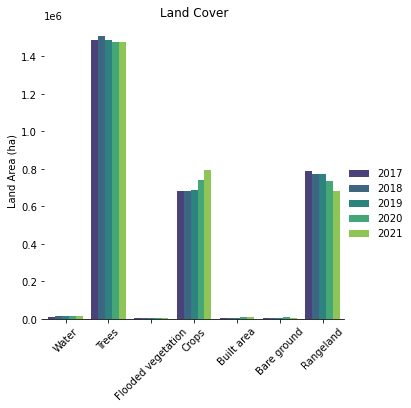

In [21]:
# Draw a nested barplot by land cover and year
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'],   #don't plot NoData pixels!
    kind="bar",
    x='Land Cover', y='cells', 
    hue="Year",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Land Area (ha)")
g.legend.set_title("")
plt.xticks(rotation=45)
plt.title("Land Cover")
plt.show()

<a name="section4"></a>
## 4. Analysing Pixel-by-Pixel Change

<a name="section5"></a>
## 5. Analysing Zonal Change

The analysis of our data above was aggregated for our entire study area. Below we'll analyse data on a pixel-by-pixel basis. But sometimes we want to work at a level in between, using zones that belong to some kind of vector geography. This is where raster _zonal statistics_ come in:

> Zonal Statistics uses groupings to calculate statistics for specified zones. [source](https://gisgeography.com/zonal-statistics/)

The statistics are summary statistics (e.g. mean, median, standard deviation) of all the pixels that fall in each zone. The zones might be watersheds, biomes or ecoregions (physically) or states, countries, counties or census districts (socio-econmically).  

Polygons will need to have the same coordinate reference system as the raster data so that they align spatially. 

In [22]:
#load shapefile for municipalities
zipfile = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/UFs/MT/MT_Municipios_2021.zip"
munis = gpd.read_file(zipfile)

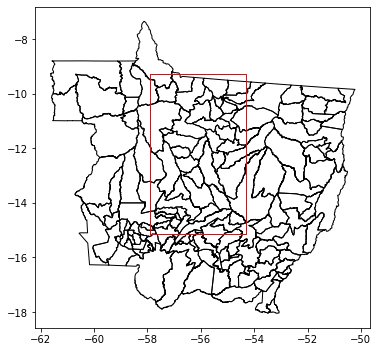

In [23]:
#plot to check study area does not cover multiple lc images 
fig, axes = plt.subplots(figsize=(6, 12))

munis.plot(edgecolor="black", facecolor="none", ax=axes)

#add polygon to show our study area
sa_polygon.plot(edgecolor="red", facecolor="none", ax=axes)

plt.show()

In [24]:
munis.head()

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry
0,5100102,Acorizal,MT,850.763,"POLYGON ((-56.22987 -14.98368, -56.22538 -14.9..."
1,5100201,Água Boa,MT,7549.308,"POLYGON ((-53.09875 -13.63518, -52.93808 -13.6..."
2,5100250,Alta Floresta,MT,8955.410,"POLYGON ((-55.86740 -9.44394, -55.86829 -9.445..."
3,5100300,Alto Araguaia,MT,5402.308,"POLYGON ((-53.23920 -16.80826, -53.23884 -16.8..."
4,5100359,Alto Boa Vista,MT,2248.414,"POLYGON ((-51.40209 -11.57606, -51.40099 -11.5..."


In [25]:
munis.dtypes

CD_MUN        object
NM_MUN        object
SIGLA         object
AREA_KM2     float64
geometry    geometry
dtype: object

In [26]:
munis['CD_MUN'] = munis['CD_MUN'].astype(int)
munis.dtypes

CD_MUN         int64
NM_MUN        object
SIGLA         object
AREA_KM2     float64
geometry    geometry
dtype: object

In [27]:
munis.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [28]:
munis = munis.to_crs(SMepsg)
sa_polygon = sa_polygon.to_crs(SMepsg)  #also reproject sa_polygon
munis.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

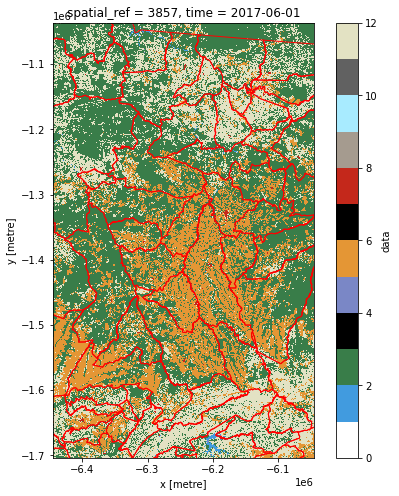

In [29]:
fig,ax1=plt.subplots(figsize=(8,8))

p = lc100['data'][0].plot(
    cmap=lc_cmap,
    vmin=vmin,
    vmax=vmax,
    ax=ax1
)

#ticks = np.linspace(start=vmin+0.5, stop=vmax-0.5, num=vmax)
#labels = [values_to_classes.get(i, "No Data") for i in range(vmax)]
#p.cbar.set_ticks(ticks, labels=labels)
#p.cbar.set_label("Land Cover Class")

munis.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

ax1.set_xlim(min(lc100['data'][0].x), max(lc100['data'][0].x)) 
ax1.set_ylim(min(lc100['data'][0].y), max(lc100['data'][0].y)) 

plt.show()

### Manipulation

crop raster to only pixels within complete counties?

In [30]:
pip_mask = munis.within(sa_polygon.loc[0, 'geometry'])
sa_munis = munis[pip_mask==True]

In [31]:
sa_munis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35 entries, 2 to 140
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CD_MUN    35 non-null     int64   
 1   NM_MUN    35 non-null     object  
 2   SIGLA     35 non-null     object  
 3   AREA_KM2  35 non-null     float64 
 4   geometry  35 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 1.6+ KB


<AxesSubplot:>

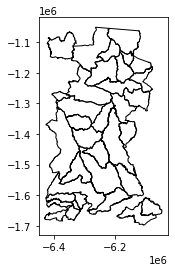

In [32]:
sa_munis.plot(facecolor='None')

In [33]:
sa_munis_shapes = sa_munis[['geometry', 'CD_MUN']].values.tolist()

In [34]:
lc100_transform = lc100['data'][0].rio.transform()
lc100_transform

Affine(300.0, 0.0, -6445800.0,
       0.0, -300.0, -1036500.0)

In [35]:
sa_munis_r = rio.features.rasterize(sa_munis_shapes, fill=-999, 
                                    out_shape=lc100['data'][0].shape, 
                                    transform=lc100_transform)  

In [36]:
sa_munis_xr = xr.DataArray(data=sa_munis_r,
                           dims=["y", "x"],
                           coords={'y':('y',lc100.y.data),
                                   'x':('x',lc100.x.data)})
sa_munis_xr

<xarray.DataArray (y: 2225, x: 1338)>
array([[-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       ...,
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999]], dtype=int32)
Coordinates:
  * y        (y) float64 -1.037e+06 -1.037e+06 ... -1.704e+06 -1.704e+06
  * x        (x) float64 -6.446e+06 -6.445e+06 ... -6.045e+06 -6.045e+06

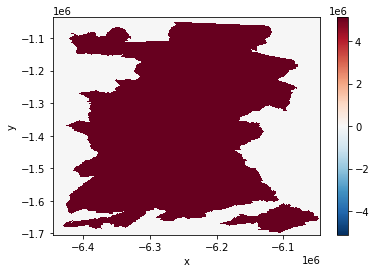

In [37]:
sa_munis_xr.plot.imshow() 

In [38]:
lc100_mask = lc100.where(sa_munis_xr >0)  #nodata was set to -999

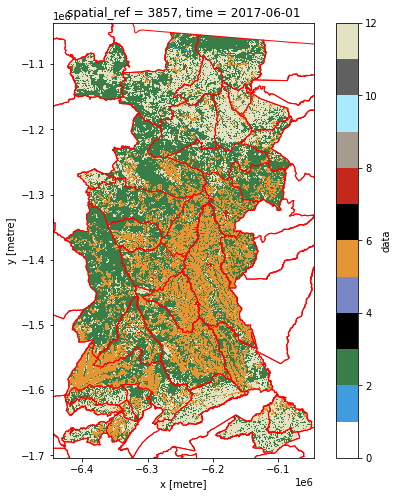

In [39]:
fig,ax1=plt.subplots(figsize=(8,8))

p = lc100_mask['data'][0].plot(
    cmap=lc_cmap,
    vmin=vmin,
    vmax=vmax,
    ax=ax1
)

#add labels when worked out above
#ticks = np.linspace(0.5, 10.5, 11)
#labels = [values_to_classes.get(i, "") for i in range(lc_cmap.N)]
#p.cbar.set_ticks(ticks, labels=labels)
#p.cbar.set_label("Class")

munis.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

ax1.set_xlim(min(lc100['data'][0].x), max(lc100['data'][0].x)) 
ax1.set_ylim(min(lc100['data'][0].y), max(lc100['data'][0].y)) 

plt.show()

### Zonal Stats

In [40]:
lc100_transform = lc100_mask['data'][0].rio.transform()
lc100_17 = np.array(lc100_mask['data'][0].astype('int32'))

In [41]:
#from rasterstats import zonal_stats
lc100_17z = zonal_stats(sa_munis, lc100_17,
                           affine=lc100_transform,
                           categorical=True)
lc100_17z   #ignore -999 warning - NoData already seems to be accounted for... (no zeros)

[{1: 467, 2: 55424, 4: 1, 5: 6225, 7: 296, 8: 79, 11: 40802},
 {2: 1298, 5: 1340, 7: 71, 11: 2264},
 {1: 390, 2: 9892, 5: 1536, 7: 49, 8: 54, 11: 16024},
 {1: 76, 2: 28919, 5: 12480, 7: 79, 8: 90, 11: 3094},
 {1: 262, 2: 10150, 4: 12, 5: 2246, 7: 118, 8: 32, 11: 23202},
 {1: 4, 2: 3926, 5: 7005, 7: 28, 8: 3, 11: 4240},
 {1: 15, 2: 33223, 4: 7, 5: 49192, 7: 188, 8: 63, 11: 15496},
 {1: 34, 2: 14085, 4: 20, 5: 24556, 7: 39, 8: 284, 11: 972},
 {1: 20, 2: 17018, 4: 5, 5: 13094, 7: 80, 8: 147, 11: 3680},
 {1: 820, 2: 34203, 4: 79, 5: 6941, 7: 35, 8: 63, 11: 10356},
 {1: 90, 2: 12272, 5: 28703, 7: 340, 8: 107, 11: 1758},
 {1: 17, 2: 11858, 4: 21, 5: 5391, 7: 105, 8: 23, 11: 29141},
 {1: 26, 2: 8113, 5: 3555, 7: 39, 8: 16, 11: 4179},
 {1: 6, 2: 15114, 4: 2, 5: 4206, 7: 30, 8: 76, 11: 8255},
 {1: 618, 2: 9902, 5: 1429, 7: 17, 11: 27368},
 {1: 650, 2: 35901, 4: 16, 5: 5528, 7: 49, 8: 88, 11: 26713},
 {1: 40, 2: 51898, 4: 16, 5: 50012, 7: 264, 8: 333, 11: 10289},
 {1: 19, 2: 5981, 5: 2891, 7: 60

In [42]:
lc100_17z_pd = pd.DataFrame(lc100_17z)

In [43]:
lc100_17z_pd.set_index(sa_munis['NM_MUN'],inplace=True)
lc100_17z_pd.head()

,1,2,4,5,7,8,11
NM_MUN,,,,,,,
Alta Floresta,467.0,55424,1.0,6225,296,79.0,40802
Arenápolis,NaN,1298,NaN,1340,71,NaN,2264
Carlinda,390.0,9892,NaN,1536,49,54.0,16024
Cláudia,76.0,28919,NaN,12480,79,90.0,3094
Colíder,262.0,10150,12.0,2246,118,32.0,23202


In [44]:
lc100_17z_pd.rename(columns=values_to_classes,inplace=True)  #use the lclabs dict we created above

lc100_17z_pd['sum']=lc100_17z_pd.sum(axis=1)

In [45]:
lc100_17z_pd.head()

,Water,Trees,Flooded vegetation,Crops,Built area,Bare ground,Rangeland,sum
NM_MUN,,,,,,,,
Alta Floresta,467.0,55424,1.0,6225,296,79.0,40802,103294.0
Arenápolis,NaN,1298,NaN,1340,71,NaN,2264,4973.0
Carlinda,390.0,9892,NaN,1536,49,54.0,16024,27945.0
Cláudia,76.0,28919,NaN,12480,79,90.0,3094,44738.0
Colíder,262.0,10150,12.0,2246,118,32.0,23202,36022.0


In [46]:
for column in lc100_17z_pd.loc[:,'Water':'Rangeland']:
    lc100_17z_pd['{}-prop'.format(column)] = lc100_17z_pd[column] / lc100_17z_pd['sum']

In [47]:
lc100_17z_pd = lc100_17z_pd.add_suffix('17')
lc100_17z_pd.head()

,Water17,Trees17,Flooded vegetation17,Crops17,Built area17,Bare ground17,Rangeland17,sum17,Water-prop17,Trees-prop17,Flooded vegetation-prop17,Crops-prop17,Built area-prop17,Bare ground-prop17,Rangeland-prop17
NM_MUN,,,,,,,,,,,,,,,
Alta Floresta,467.0,55424,1.0,6225,296,79.0,40802,103294.0,0.004521,0.536566,0.000010,0.060265,0.002866,0.000765,0.395008
Arenápolis,NaN,1298,NaN,1340,71,NaN,2264,4973.0,NaN,0.261009,NaN,0.269455,0.014277,NaN,0.455258
Carlinda,390.0,9892,NaN,1536,49,54.0,16024,27945.0,0.013956,0.353981,NaN,0.054965,0.001753,0.001932,0.573412
Cláudia,76.0,28919,NaN,12480,79,90.0,3094,44738.0,0.001699,0.646408,NaN,0.278957,0.001766,0.002012,0.069158
Colíder,262.0,10150,12.0,2246,118,32.0,23202,36022.0,0.007273,0.281772,0.000333,0.062351,0.003276,0.000888,0.644106


In [48]:
lc100_17z_pd = pd.merge(sa_munis, lc100_17z_pd, how='left', left_on = 'NM_MUN', right_index=True)
lc100_17z_pd.head()

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry,Water17,Trees17,Flooded vegetation17,Crops17,Built area17,Bare ground17,Rangeland17,sum17,Water-prop17,Trees-prop17,Flooded vegetation-prop17,Crops-prop17,Built area-prop17,Bare ground-prop17,Rangeland-prop17
2,5100250,Alta Floresta,MT,8955.410,"POLYGON ((-6219130.124 -1056088.035, -6219229....",467.0,55424,1.0,6225,296,79.0,40802,103294.0,0.004521,0.536566,0.000010,0.060265,0.002866,0.000765,0.395008
12,5101308,Arenápolis,MT,417.337,"POLYGON ((-6330913.103 -1615920.187, -6330922....",NaN,1298,NaN,1340,71,NaN,2264,4973.0,NaN,0.261009,NaN,0.269455,0.014277,NaN,0.455258
26,5102793,Carlinda,MT,2421.788,"POLYGON ((-6212162.920 -1088961.922, -6211814....",390.0,9892,NaN,1536,49,54.0,16024,27945.0,0.013956,0.353981,NaN,0.054965,0.001753,0.001932,0.573412
29,5103056,Cláudia,MT,3843.561,"POLYGON ((-6153965.646 -1263744.447, -6153909....",76.0,28919,NaN,12480,79,90.0,3094,44738.0,0.001699,0.646408,NaN,0.278957,0.001766,0.002012,0.069158
31,5103205,Colíder,MT,3112.091,"POLYGON ((-6175226.198 -1146318.365, -6175285....",262.0,10150,12.0,2246,118,32.0,23202,36022.0,0.007273,0.281772,0.000333,0.062351,0.003276,0.000888,0.644106


<AxesSubplot:>

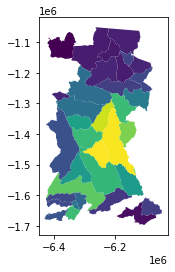

In [49]:
lc100_17z_pd.plot('Crops-prop17')

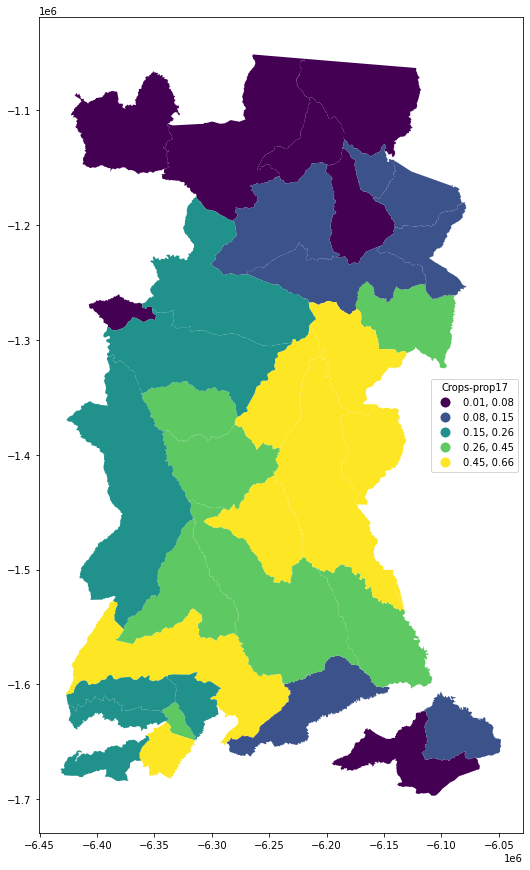

In [50]:
col = 'Crops-prop17'

fig, ax = plt.subplots(1, figsize=(9, 15))

lc100_17z_pd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 5},
        ax=ax
       )

plt.show()

In [ ]:
'''
#xarray-spatial zonal_Stats

munis_shapes = munis[['geometry', 'CD_MUN']].values.tolist()
#checks
#munis_shapes
#type(lc100['data'][0])
#lc100['data'][0].shape
lc100_transform = lc100['data'][0].rio.transform()
#lc100_transform
lc100r = rio.features.rasterize(munis_shapes, fill=-999, out_shape=lc100['data'][0].shape, transform=lc100_transform)  
lc100r_xr = xr.DataArray(lc100r)
#lc100r_xr.plot.imshow() 
#lat is flipped (why?), reverse this https://stackoverflow.com/q/54677161
lc100r_xr = lc100r_xr.reindex(dim_0=lc100r_xr.dim_0[::-1])  
#lc100r_xr.plot.imshow() 

#convert to same type as zonal xarray
lc100_np = np.array(lc100['data'][0].astype('int32'))
lc100_int = xr.DataArray(lc100_np)
#lc100_int

zonal_stats(lc100r_xr, lc100_int)  #xarray-spatial zonal_Stats

#use custom stats to calculate lc mode for each region (edit below) 
#custom_stats = dict(
#https://www.delftstack.com/howto/numpy/python-numpy-mode/#calculate-the-mode-of-a-numpy-arraywith-the-numpy-unique-function
#    mode=lambda zone: zone.max() - zone.min(),
#    elevation_min=np.min,
#    elevation_max=np.max,
#)

ad = np.array([1, 2, 6, 4, 6, 3, 6])

def modal_cover(ar):
    vals,counts = np.unique(ar, return_counts=True)
    index = np.argmax(counts)
    return vals[index]
    
#d = modal_cover(ad)

custom_stats = dict(
    mode=lambda zone: modal_cover(zone)
)

zonal_stats(lc100r_xr, lc100_int, stats_funcs=custom_stats)
'''

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [52]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-08-03
